In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from skbio.diversity import alpha_diversity, beta_diversity
import random
import functools
# from skbio.stats.ordination import pcoa, pcoa_biplotb
import random
from os.path import join
import pandas as pd
import xlsxwriter
import openpyxl
import os
import numpy as np
from pandas import Series, ExcelWriter
import scipy.io as sio
import scipy
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 
from anndata import AnnData
import warnings
warnings.filterwarnings('ignore')
import importlib

In [88]:
import sys  
sys.path.insert(0, '../my_packages')
import dimen_reduc
import meta_ord
import paga_res
import sliding_window
import statistic
from roc_ps import get_shuffled_df, get_roc, all_func
# importlib.reload(dimen_reduc)
# importlib.reload(meta_ord)
# importlib.reload(paga_res)
# importlib.reload(sliding_window)
# importlib.reload(statistic)

####  Variables

In [89]:
file_path = '../data/'

file_name = file_path + 'ps_res_PCA_umap_02072023.xlsx'
nn_file_name = file_path + 'nn_res_PCA_umap_02072023.xlsx'

sheet_abun = 'abundance'
sheet_meta = 'meta'
sheet_umap = 'umap'
sheet_pcoa = 'pcoa'

In [ ]:
# 0. Load data
## Pseudotime validation
# 1. ROC BV indicators
# 2. Menstruation delta
# 3. Metabolites
## Longitudinal only
# 4. BV medications
# 5. ROC BV from first days ps prediction
# 6. Bacterial abundance in arms

#### 0. Load data

In [90]:
meta = pd.read_excel(file_name, sheet_name = sheet_meta, index_col = 0)
nn_meta = pd.read_excel(nn_file_name, sheet_name = sheet_meta, index_col = 0)
display(meta.shape)
display(nn_meta.shape)

(8026, 35)

(515, 37)

In [91]:
def get_bv_status(df):
    ## BV status
    conditions_status = [(df['ABV'] == 1), (df['SBV'] == 1),
    ((df['db'] == 'temp_pyro') & (df['BV_status'].isnull()))]
    values_status = ['ABV', 'SBV', 'HC']

    df['BV_status'] = np.select(conditions_status, values_status, default = df['BV_status'])
    
    ## BV bin
    conditions_bin = [((df['BV_status'] == 'ABV') | (df['BV_status'] == 'SBV')),
        (df['BV_status'] == 'HC')]
    values_bin = [1, 0]

    df['BV_bin'] = np.select(conditions_bin, values_bin, default = df['BV_status'])
    
    return df

In [92]:
meta = get_bv_status(meta)
nn_meta = get_bv_status(nn_meta)

#### 1. ROC BV indicators

In [93]:
def order_meta(func_meta, nn):
    if nn:
        roc_meta = func_meta.copy()
    else: 
        roc_meta = func_meta[func_meta['root'] == 'reg']
    
    roc_meta['nugent_bin'] = (np.select([roc_meta['nugent'] >= 7, roc_meta['nugent'].isnull(), roc_meta['nugent'] < 7], [1, np.nan, 0]))                  
    roc_meta['ph_bin'] = (np.select([roc_meta['ph'] >= 5.5, roc_meta['ph'].isnull(), roc_meta['ph'] < 5.5], [1, np.nan, 0]))
    meta_amsel = roc_meta[roc_meta['db'].isin(['carter', 'temp_pyro', 'srin'])]
    meta_amsel['BV_amsel_bin'] = np.where((meta_amsel['BV_status'] == 'ABV') | (meta_amsel['BV_status'] == 'SBV'), 1, 0)
    
    return roc_meta, meta_amsel

def view_distributions(meta, cols =  ['nugent_bin', 'ph_bin', 'BV_amsel_bin', 'whiff', 'clue', 'vag_fluid']):
    
    return

def run_roc(roc_meta, meta_amsel, nn, path, save = True, cols = ['nugent_bin', 'ph_bin', 'BV_amsel_bin', 'whiff', 'clue', 'vag_fluid']):
    roc_dict = {}
    
    for col in cols:
        if col in ['nugent_bin', 'ph_bin']:
            df, shuff = all_func(roc_meta, 99, col)
        else:
            df, shuff = all_func(meta_amsel, 99, col)
        roc_dict[col] = df
    if nn:
        path = file_path + 'nn_' + path
    else:
        path = file_path + path
    
    if save:
        paga_res.save_excel(path, roc_dict)
    
    return roc_dict

def all_roc_func(meta, nn, path, save = True, cols = ['nugent_bin', 'ph_bin', 'BV_amsel_bin', 'whiff', 'clue', 'vag_fluid']):
    roc_meta, meta_amsel = order_meta(meta, nn)
#     fig = view_distributions(meta, cols =  ['nugent_bin', 'ph_bin', 'BV_amsel_bin', 'whiff', 'clue', 'vag_fluid'])
    roc_dict = run_roc(roc_meta, meta_amsel, nn, path, save = save, cols = cols)
    
    return roc_dict

In [94]:
roc_dict = all_roc_func(meta, nn = False, path = 'roc_res_PCA_umap_30072023.xlsx', save = True)
nn_roc_dict = all_roc_func(nn_meta, nn = True, path = 'roc_res_PCA_umap_30072023.xlsx', save = True, cols = ['nugent_bin', 'ph_bin', 'BV_amsel_bin'])

In [59]:
dict_metabolites = {'meta': meta, 'nn_meta': nn_meta}
metabolic_path = file_path + 'corrected_meta.xlsx'
paga_res.save_excel(metabolic_path, dict_metabolites)

#### 2. Menstruation delta

In [95]:
def get_menst(meta, 
              nn,
              path,
              save_cols = ['subjectID', 'CST', 'subCST', 'time', 'day', 'week', 'mt_pseudotime', 'menst', 
                           'ps_diff', 'ps_diff_abs','sum_all'],
             save = True):
    # Filter only to temporal samples
    temp_meta = meta[meta['sampleID'].str.contains('UAB')]
    temp_meta['menst'] = np.where(temp_meta['menst'] >= 1 , 1, 0)
    print('Temporal samples shape: ' + str(temp_meta.shape))
    
    # Pseudotime calculation
    temp_meta['prev_pseudotime'] = temp_meta.groupby('subjectID')['mt_pseudotime'].shift(periods = 1)
    temp_meta['ps_diff'] = temp_meta['mt_pseudotime'] - temp_meta['prev_pseudotime']
    temp_meta['ps_diff_abs'] = temp_meta['ps_diff'].abs()
    
    # Menstruation calculation
    tmp = temp_meta[['time', 'subjectID', 'menst']]
    tmp['prev_menst1'] = tmp.groupby('subjectID')['menst'].shift(periods = -1)
    tmp['prev_menst2'] = tmp.groupby('subjectID')['menst'].shift(periods = -2)
    tmp['next_menst1'] = tmp.groupby('subjectID')['menst'].shift(periods = 1)
    tmp['next_menst2'] = tmp.groupby('subjectID')['menst'].shift(periods = 2)
    tmp['sum_all'] = tmp.loc[:,tmp.columns.str.contains('menst')].sum(axis = 1)
    tmp['sum_all'][tmp['sum_all'] >= 1] = 1
    temp_menst_meta = temp_meta.join(tmp[['sum_all']])
    print('Menstruation samples number: ')
    display(temp_menst_meta.groupby('sum_all')['CST'].count())
    
    if save:
        save_cols = save_cols
        dict_menst = {'meta': temp_menst_meta[save_cols]}
        if nn: 
            menst_path = file_path + 'nn_' + path
        else:
            menst_path = file_path + path
            
        paga_res.save_excel(menst_path, dict_menst)    
    
    return temp_menst_meta

In [96]:
menst_meta = get_menst(meta, False, 'menst_statistics_res_PCA_umap_02072023.xlsx')
menst_meta = get_menst(nn_meta, True, 'menst_statistics_res_PCA_umap_02072023.xlsx')

Temporal samples shape: (3112, 35)
Menstruation samples number: 


sum_all
0.0    1739
1.0    1373
Name: CST, dtype: int64

Temporal samples shape: (485, 37)
Menstruation samples number: 


sum_all
0.0    214
1.0    271
Name: CST, dtype: int64

#### 3. Metabolites

In [97]:
metabolic_filename = file_path + 'Borgogna_meta.xlsx'
metabolic_meta = pd.read_excel(metabolic_filename, sheet_name = 'meta', index_col = 0)
display(metabolic_meta.shape)

(119, 13)

In [98]:
met_cols = [col for col in metabolic_meta.columns if 'ine' in col]
met_cols.append('total')
metabolic_meta = meta.merge(metabolic_meta[met_cols], left_on = 'sampleID', right_index = True)
metabolic_meta['high_ps'] = np.where(metabolic_meta['mt_pseudotime'] >= 0.9, 1, 0)

In [99]:
dict_metabolites = {'meta': metabolic_meta[['subjectID', 'mt_pseudotime', 'Cadaverine', 'Putrescine', 'Spermidine', 'Spermine', 'Tyramine', 'total', 'high_ps']]}
metabolic_path = file_path + 'metabolites_with_ps_PCA_umap.xlsx'
paga_res.save_excel(metabolic_path, dict_metabolites)

#### 4. BV medication

In [105]:
both_meta = pd.concat([meta, nn_meta])
both_meta_temp = both_meta[both_meta['db'] == 'temp_pyro']

In [117]:
def flatten_lst(lst):
    return [item for items in lst for item in items]

def select_df_by_indices(df, idx_lsts, predict_group_size, bv_next = 1):
    groups_names = [[i] * (len(x)) for i, x in enumerate(idx_lsts)]
    flatten_idx_lst = flatten_lst(idx_lsts)
    flatten_names_lst = flatten_lst(groups_names)
    
    new_df = df.iloc[flatten_idx_lst]
    new_df['group_name'] = flatten_names_lst
    new_df['bv_next'] = bv_next
    
    return new_df

def ps_before_bv(meta, obj_col, num_days, predict_group_size = 7):
    # Order by subjectID and time
    temp_meta = meta[(meta['db'] == 'temp_pyro')]# & meta['subjectID'].isin(high_std_subjects)]
    temp_meta_no = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, False]).reset_index()
    temp_meta_no['cumcount_time'] = temp_meta_no.groupby(['subjectID']).cumcount().add(1)
    
    # Get indices of medication and after
    bv_samples_idx = temp_meta_no[(temp_meta_no[obj_col] == 1) & (temp_meta_no['cumcount_time'] > num_days)].index
    
    # Get before samples and filter df
    before_bv_lists = [list(range(num - num_days, num + 1)) for num in bv_samples_idx]
    before_bv_df = select_df_by_indices(temp_meta_no, before_bv_lists, predict_group_size = predict_group_size)
    
    return before_bv_df

In [108]:
def ps_after(meta, obj_col, high_std_subjects, predict_group_size = 4):
    # Order by subjectID and time
    temp_meta = meta[(meta['db'] == 'temp_pyro') & meta['subjectID'].isin(high_std_subjects)]
    temp_meta_no = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, False]).reset_index()
    temp_meta_no['cumcount_time'] = temp_meta_no.groupby(['subjectID']).cumcount().add(1)
    
    # Get indices of medication and after
    med_samples_idx = temp_meta_no[(temp_meta_no[obj_col] == 1) & (temp_meta_no['cumcount_time'] > 1)].index
    
    # Filter consecutive indices 
    grouped_after_med_idx = functools.reduce(lambda x,y : x[:-1] + [x[-1]+[y]] if (x[-1][-1]+1 == y) else [*x,[y]], med_samples_idx[1:] , [[med_samples_idx[0]]])
#     high_after_med_idx = [min(lst) for lst in grouped_after_med_idx]
    
    # Get after samples and filter df
    after_med_lists = grouped_after_med_idx.copy()
    [lst.extend([lst[0] - 1, lst[-1] + 1]) for lst in after_med_lists]
    after_med_df = select_df_by_indices(temp_meta_no, after_med_lists, predict_group_size = predict_group_size)
    
    return after_med_df, med_samples_idx, grouped_after_med_idx, after_med_lists, temp_meta_no

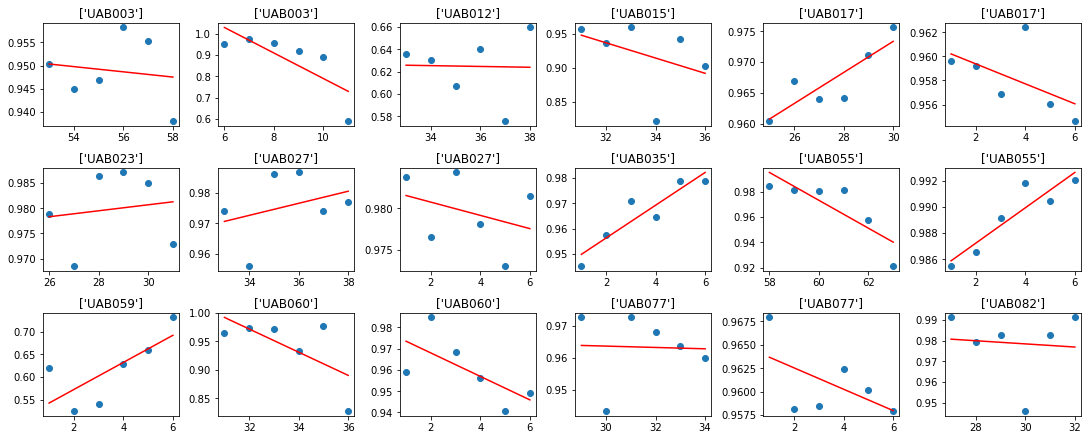

In [123]:
before_bv_df = ps_before_bv(both_meta_temp, 'BV_bin', 5, 5)

subjects_num = len(after_med_df.group_name.unique())#len(filt_before_bv_df.group_name.unique())
nrow = 3
ncol = 6 #subjects_num // nrow 
fig, axes = plt.subplots(nrow, ncol, figsize = (15, 6), constrained_layout=True)
for group, ax in zip(before_bv_df.group_name.unique(), axes.flat):
    plot_df = before_bv_df[before_bv_df['group_name'] == group].sort_values('time')
    subject = plot_df.subjectID.unique()
    x = plot_df['time']
    y = plot_df['mt_pseudotime']
    c = plot_df['BV_medication']
    ax.set_title(subject)
    ax.scatter(x, y)#, c)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m * x + b, color='red')

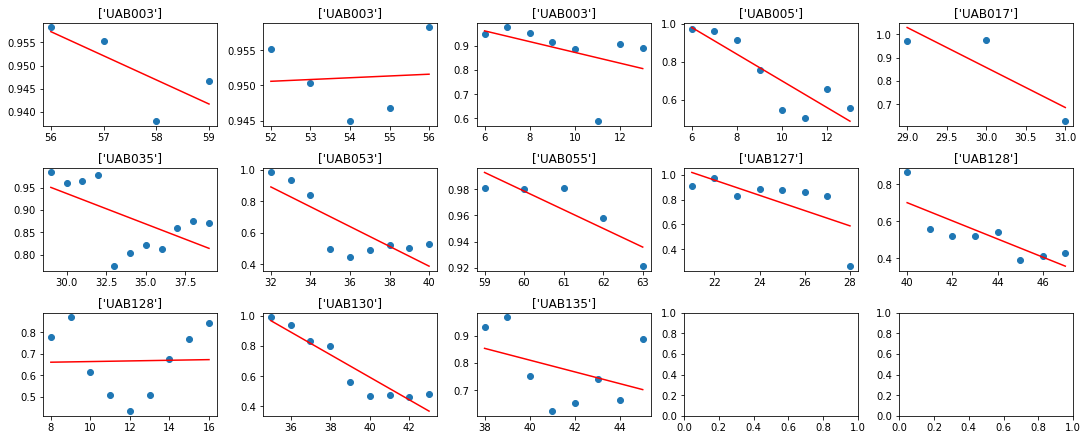

In [109]:
after_med_df, med_samples_idx, grouped_after_med_idx, after_med_lists, temp_meta_no = ps_after(both_meta, 'BV_medication', high_std_subjects, predict_group_size = 4)

subjects_num = len(after_med_df.group_name.unique())#len(filt_before_bv_df.group_name.unique())
nrow = 3
ncol = 5 #subjects_num // nrow 
fig, axes = plt.subplots(nrow, ncol, figsize = (15, 6), constrained_layout=True)
for group, ax in zip(after_med_df.group_name.unique(), axes.flat):
    plot_df = after_med_df[after_med_df['group_name'] == group].sort_values('time')
    subject = plot_df.subjectID.unique()
    x = plot_df['time']
    y = plot_df['mt_pseudotime']
    c = plot_df['BV_medication']
    ax.set_title(subject)
    ax.scatter(x, y)#, c)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m * x + b, color='red')

In [124]:
med_dict = {'meta': after_med_df}
med_path = file_path + 'after_medication_ps_15082023.xlsx'
paga_res.save_excel(med_path, med_dict)

#### 6. Bacterial abundance in arms

In [68]:
in_df = pd.read_excel(file_name, sheet_name = sheet_abun, index_col = 0)
display(in_df.shape)

(8026, 373)

In [69]:
window_size = 0.2
increment = 0.01
n = 12

In [70]:
abun_df_lst = []
branch_df_lst = []
sumsort_branch_df_lst = []

for branch in meta.CST.unique():
    abun_df, final_window_df, sumsort_window_df = sliding_window.all_window_proc(in_df, 
                                                  meta, branch, 'subCST', 'IV-C0',  window_size, increment, n)
    abun_df_lst.append(abun_df)
    branch_df_lst.append(final_window_df)
    sumsort_branch_df_lst.append(sumsort_window_df)

In [71]:
sum_spec_lst = ['Bifidobacterium', 'Prevotella', 'Staphylococcus', 'Sneathia','Atopobium', 'Mobiluncus', 
            'Finegoldia', 'Corynebacterium', 'Aerococcus', 'Streptococcus']

In [72]:
sum_branch_df_lst = []
for i, branch in enumerate(meta.CST.unique()):
    df = sumsort_branch_df_lst[i].copy()
    for spec in sum_spec_lst:
        sum_cols = [col for col in df.columns if spec in col]
        sum_col_name = spec + '_' + branch
        if len(sum_cols) > 1:
            df[sum_col_name] = df[sum_cols].sum(axis = 1)
            df.drop(sum_cols, axis = 1, inplace = True)
        elif len(sum_cols) == 1:
            df = df.rename(columns = {sum_cols[0]: sum_col_name})
    sum_branch_df_lst.append(df)

In [73]:
ord_df = sliding_window.get_order(sum_branch_df_lst)
melt_df = sliding_window.get_melt(ord_df)
melt_df['species'] = melt_df['species'].replace({'o_': '', 'g_': ''})

In [ ]:
dict_melt = {'melt_branch_df': melt_df}
melt_path = file_path + 'branch_melt_df_PCA_umap_02072023.xlsx'
paga_res.save_excel(melt_path, dict_melt)

In [79]:
fig = px.scatter(melt_df[melt_df['branch'].isin(['I', 'II', 'III', 'V'])], x = 'mt_pseudotime', y = 'value', color = 'species', 
           facet_col = 'branch', facet_col_wrap = 2)
fig.update_layout(autosize = False, width = 1000, height = 600)
fig.update_yaxes(matches = None)
fig.show()

In [86]:
h_df = melt_df[melt_df['branch'].isin(['I', 'II', 'III', 'V'])]
grouped_spec_df = h_df.loc[h_df.groupby(['species', 'branch'])['mt_pseudotime'].idxmax()].reset_index(drop=True)
for spec in grouped_spec_df.species.unique():
    display(grouped_spec_df[grouped_spec_df['species'] == spec])

,mt_pseudotime,value,species,branch
0,0.903329,1.023924,Aerococcus,III


,mt_pseudotime,value,species,branch
1,0.903329,1.722224,Atopobium,III


,mt_pseudotime,value,species,branch
2,0.878535,2.914763,Bifidobacterium,II
3,0.880174,0.633962,Bifidobacterium,V


,mt_pseudotime,value,species,branch
4,0.852677,0.948599,Corynebacterium,I
5,0.878535,2.180855,Corynebacterium,II
6,0.880174,0.935976,Corynebacterium,V


,mt_pseudotime,value,species,branch
7,0.852677,1.187691,Finegoldia,I
8,0.878535,1.996439,Finegoldia,II
9,0.903329,0.643158,Finegoldia,III
10,0.880174,0.815315,Finegoldia,V


,mt_pseudotime,value,species,branch
11,0.852677,9.273553,Gardnerella_vaginalis,I
12,0.878535,2.809080,Gardnerella_vaginalis,II
13,0.903329,11.375882,Gardnerella_vaginalis,III
14,0.880174,7.722860,Gardnerella_vaginalis,V


,mt_pseudotime,value,species,branch
15,0.852677,2.767380,Lactobacillus_Cluster_1,I
16,0.878535,6.733157,Lactobacillus_Cluster_1,II
17,0.903329,0.788965,Lactobacillus_Cluster_1,III
18,0.880174,0.744625,Lactobacillus_Cluster_1,V


,mt_pseudotime,value,species,branch
19,0.852677,47.481706,Lactobacillus_crispatus,I
20,0.878535,2.428743,Lactobacillus_crispatus,II
21,0.903329,6.341399,Lactobacillus_crispatus,III
22,0.880174,6.916134,Lactobacillus_crispatus,V


,mt_pseudotime,value,species,branch
23,0.852677,4.068635,Lactobacillus_gasseri,I
24,0.878535,57.738151,Lactobacillus_gasseri,II
25,0.903329,0.545171,Lactobacillus_gasseri,III
26,0.880174,3.919357,Lactobacillus_gasseri,V


,mt_pseudotime,value,species,branch
27,0.852677,11.420651,Lactobacillus_iners,I
28,0.878535,1.415047,Lactobacillus_iners,II
29,0.903329,56.607788,Lactobacillus_iners,III
30,0.880174,17.671912,Lactobacillus_iners,V


,mt_pseudotime,value,species,branch
31,0.852677,6.506507,Lactobacillus_jensenii,I
32,0.878535,1.256917,Lactobacillus_jensenii,II
33,0.903329,3.251072,Lactobacillus_jensenii,III
34,0.880174,52.295432,Lactobacillus_jensenii,V


,mt_pseudotime,value,species,branch
35,0.880174,0.372666,Lactobacillus_psittaci,V


,mt_pseudotime,value,species,branch
36,0.852677,12.113529,Others,I
37,0.878535,13.390588,Others,II
38,0.903329,14.539802,Others,III
39,0.880174,6.476621,Others,V


,mt_pseudotime,value,species,branch
40,0.878535,2.25129,Prevotella,II


,mt_pseudotime,value,species,branch
41,0.852677,1.332940,Streptococcus,I
42,0.878535,2.028280,Streptococcus,II
43,0.903329,0.953223,Streptococcus,III
44,0.880174,0.907396,Streptococcus,V


,mt_pseudotime,value,species,branch
45,0.852677,0.978431,g_Anaerococcus,I
46,0.878535,2.851091,g_Anaerococcus,II


,mt_pseudotime,value,species,branch
47,0.903329,1.93417,g_Megasphaera,III


,mt_pseudotime,value,species,branch
48,0.852677,0.890701,g_Peptoniphilus,I
49,0.880174,0.587043,g_Peptoniphilus,V


,mt_pseudotime,value,species,branch
50,0.852677,1.026597,g_Pseudomonas,I


,mt_pseudotime,value,species,branch
51,0.903329,0.272588,g_Ureaplasma,III


In [57]:
filt_df = grouped_spec_df[(grouped_spec_df['value'] > 0.01) & (grouped_spec_df['branch'].isin(['I','II','III','V']))]#.sort_values(['value', 'species'])
high_spec = filt_df.species.value_counts() == 4
high_spec[high_spec]
filt_df[~filt_df['species'].isin(high_spec[high_spec].index)].groupby('species').agg({'value' : ['count', 'mean']})

value          
                       count      mean
species                               
Aerococcus                 1  1.023924
Atopobium                  1  1.722224
Bifidobacterium            2  1.774362
Corynebacterium            3  1.355143
Lactobacillus_psittaci     1  0.372666
Prevotella                 1  2.251290
g_Anaerococcus             2  1.914761
g_Megasphaera              1  1.934170
g_Peptoniphilus            2  0.738872
g_Pseudomonas              1  1.026597
g_Ureaplasma               1  0.272588

In [61]:
filt_df.sort_values('value', ascending = False)

,mt_pseudotime,value,species,branch
37,0.878535,57.738151,Lactobacillus_gasseri,II
43,0.903329,56.607788,Lactobacillus_iners,III
52,0.880174,52.295432,Lactobacillus_jensenii,V
29,0.852677,47.481706,Lactobacillus_crispatus,I
47,0.880174,17.671912,Lactobacillus_iners,V
57,0.903329,14.539802,Others,III
56,0.878535,13.390588,Others,II
55,0.852677,12.113529,Others,I
41,0.852677,11.420651,Lactobacillus_iners,I
18,0.903329,11.375882,Gardnerella_vaginalis,III
